In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('mf_data.xlsx')

In [3]:
df.head()

,datetime,tanaon,guihean,upper_amusig,lower_amusig,mf1_1,mf1_2,mf1_3,mf1_4,mf2_1,mf2_2,mf2_3,mf2_4
0,2021-01-01 01:00:00,0.26,0.16,0.34,0.2,5800.0,5900.0,NaN,NaN,3700.0,3700.0,3400.0,3400.0
1,2021-01-01 02:00:00,0.26,0.16,0.34,0.2,5800.0,5900.0,NaN,NaN,3700.0,3700.0,3300.0,3400.0
2,2021-01-01 03:00:00,0.26,0.16,0.35,0.2,5800.0,5700.0,NaN,NaN,3700.0,3700.0,3300.0,3300.0
3,2021-01-01 04:00:00,0.26,0.16,0.35,0.2,5700.0,5600.0,NaN,NaN,3600.0,3600.0,3300.0,3300.0
4,2021-01-01 05:00:00,0.26,0.16,0.35,0.2,5700.0,5600.0,NaN,NaN,3600.0,3600.0,3300.0,3300.0


In [4]:
df_=df.copy()

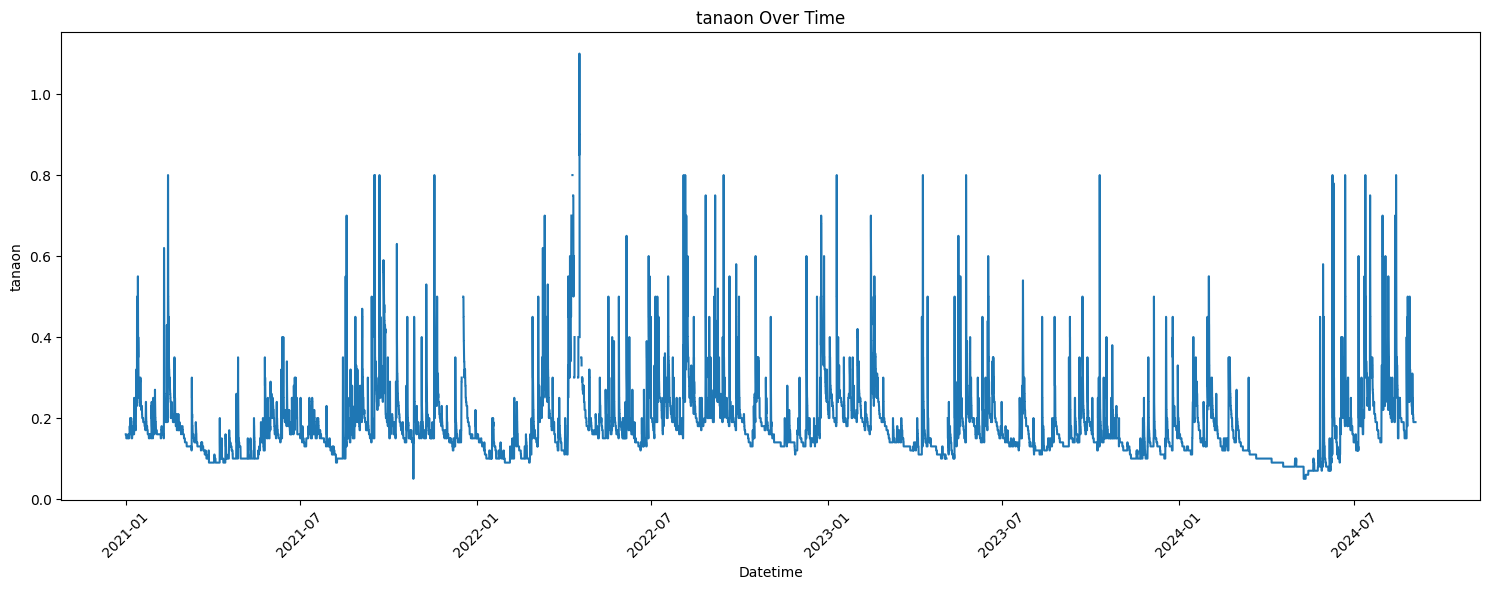

In [5]:


plt.figure(figsize=(15, 6))  # Adjust width and height as needed
plt.plot(df_['datetime'], df_['guihean'])
plt.xlabel('Datetime')
plt.ylabel('tanaon')
plt.title('tanaon Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [10]:
# Replace zeros in 'guihean' where the value is greater than 2 or less than 0.
df_.loc[(df_['guihean'] > 0.9) | (df_['guihean'] < 0), 'guihean'] = 0
df_['guihean'] = df_['guihean'].replace(0, pd.NA).ffill()

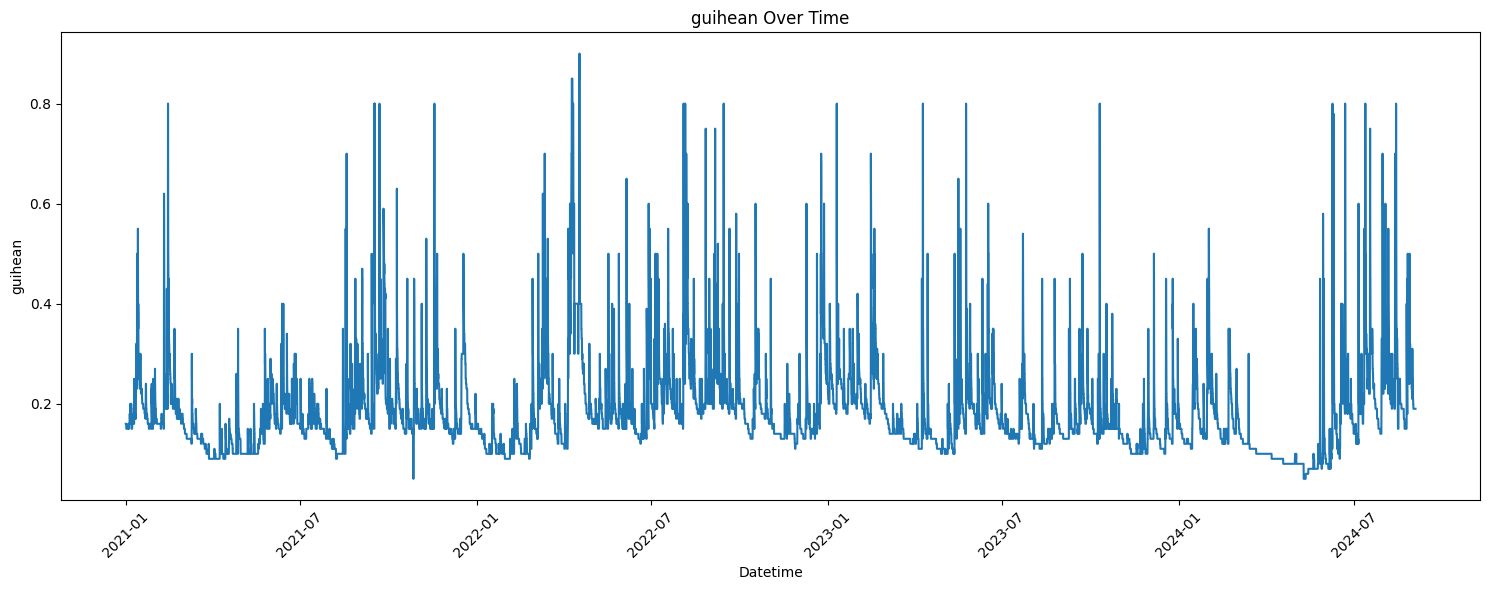

In [11]:
plt.figure(figsize=(15, 6))  # Adjust width and height as needed
plt.plot(df_['datetime'], df_['guihean'])
plt.xlabel('Datetime')
plt.ylabel('guihean')
plt.title('guihean Over Time')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [12]:
df_mf_guihean = df_[['datetime', 'guihean']]
df_mf_guihean.to_excel('df_mf_guihean.xlsx')

In [13]:
df_mf_guihean = pd.read_excel('df_mf_guihean.xlsx')

In [14]:
df_mf_guihean = df_mf_guihean.drop(columns=['Unnamed: 0' ])
df_mf_guihean.head()


,datetime,guihean
0,2021-01-01 01:00:00,0.16
1,2021-01-01 02:00:00,0.16
2,2021-01-01 03:00:00,0.16
3,2021-01-01 04:00:00,0.16
4,2021-01-01 05:00:00,0.16


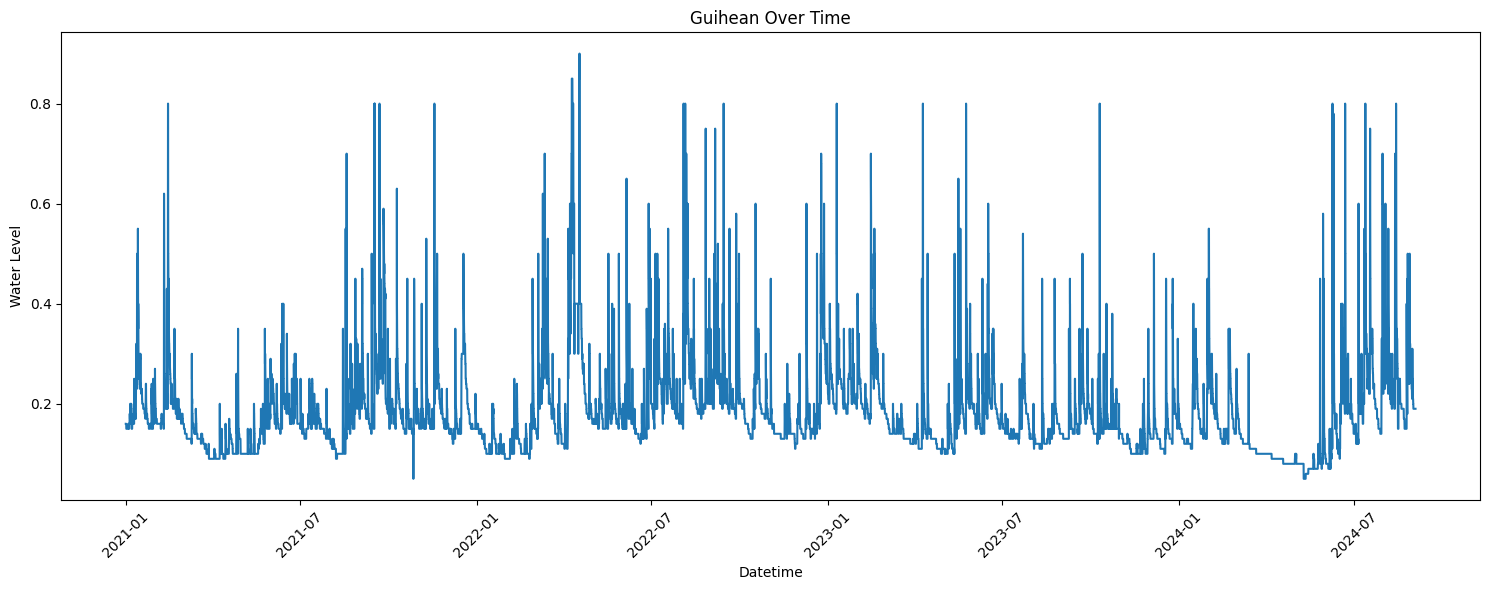

In [16]:
plt.figure(figsize=(15, 6))  # Adjust width and height as needed
plt.plot(df_mf_guihean['datetime'], df_mf_guihean['guihean'])
plt.xlabel('Datetime')
plt.ylabel('Water Level')
plt.title('Guihean Over Time')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [18]:
import tensorflow as tf
import keras
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [19]:

scaler = MinMaxScaler(feature_range=(0,1))
level_data_scaled = scaler.fit_transform(df_mf_guihean['guihean'].values.reshape(-1,1))

sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(level_data_scaled)):
    X.append(level_data_scaled[i-sequence_length:i, 0])
    y.append(level_data_scaled[i, 0])

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input
from keras.models import Model 
import tensorflow as tf

from keras.callbacks import EarlyStopping

# Define input shape explicitly
input_shape = (X_train.shape[1], 1)
model_input = Input(shape=input_shape)

# Adding LSTM layers with return_sequences=True
x = LSTM(units=50, return_sequences=True)(model_input)
x = LSTM(units=50, return_sequences=True)(x)

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')

# Instead of model.add, create new layers and connect them
x = Dropout(0.2)(x)  # Apply Dropout to the output of the previous layer
x = BatchNormalization()(x)  # Apply Batch Normalization
# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, X_train.shape[1]))(x)
attention_result = attention([x, x]) # Use the output of the last layer (x)
x = Multiply()([x, attention_result])
# Return to original shape
x = Permute((2, 1))(x)
x = Reshape((-1, 50))(x)

# Adding a Flatten layer before the final Dense layer
x = tf.keras.layers.Flatten()(x)

# Final Dense layer
model_output = Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs=model_input, outputs=model_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
823/823 [==============================] - 60s 70ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 2/100
823/823 [==============================] - 47s 57ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/100
823/823 [==============================] - 46s 56ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/100
823/823 [==============================] - 47s 57ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/100
823/823 [==============================] - 47s 57ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/100
823/823 [==============================] - 50s 60ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/100
823/823 [==============================] - 51s 62ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
823/823 [==============================] - 52s 63ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
823/823 [==============================] - 53s 65ms/step - loss: 0.0012 - val_loss: 9.3594e-04
Epoch 10/100
823/823 [==============================] - 54s 65ms/step

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 60, 50)       10400       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 60, 50)       20200       ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 60, 50)       0           ['lstm_1[0][0]']                 
                                                                                              

In [23]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
# model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
823/823 [==============================] - 57s 69ms/step - loss: 7.9259e-04 - val_loss: 8.8972e-04 - lr: 0.0010
Epoch 2/100
823/823 [==============================] - 57s 70ms/step - loss: 8.0122e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 3/100
823/823 [==============================] - 58s 70ms/step - loss: 7.9046e-04 - val_loss: 7.9883e-04 - lr: 0.0010
Epoch 4/100
823/823 [==============================] - 57s 70ms/step - loss: 7.9462e-04 - val_loss: 7.8213e-04 - lr: 0.0010
Epoch 5/100
823/823 [==============================] - 60s 73ms/step - loss: 8.0006e-04 - val_loss: 7.9593e-04 - lr: 0.0010
Epoch 6/100
823/823 [==============================] - 58s 70ms/step - loss: 7.8856e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 7/100
823/823 [==============================] - 59s 71ms/step - loss: 7.8833e-04 - val_loss: 7.8477e-04 - lr: 0.0010
Epoch 8/100
823/823 [==============================] - 59s 71ms/step - loss: 7.9131e-04 - val_loss: 7.4761e-04 - lr: 0.0010
Epoch 9/100
823/

In [24]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)


201/201 [==============================] - 4s 21ms/step - loss: 8.5755e-04
Test Loss:  0.0008575490792281926


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

201/201 [==============================] - 5s 20ms/step
Mean Absolute Error:  0.007209863472514197
Root Mean Square Error:  0.029283936809364485


In [26]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

In [ ]:
mf1_guihean = df_mf_guihean['guihean'].values[-60:]  # Last 60 days

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(mf1_guihean.reshape(-1, 1))

# Make predictions
predicted_level = []
current_batch = scaled_data.reshape(1, 60, 1)

predictions = model.predict(current_batch)

1/1 [==============================] - 1s 545ms/step


In [28]:
for i in range(24):  # Predicting 24 hours
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_level.append(scaler.inverse_transform(next_prediction)[0, 0])

1/1 [==============================] - 0s 36ms/step


In [29]:
for i, level in enumerate(predicted_level, 1):
    print(f"Hour {i} prediction: {level}")

Hour 1 prediction: 0.1896948665380478
Hour 2 prediction: 0.18912538886070251
Hour 3 prediction: 0.18776103854179382
Hour 4 prediction: 0.1853928416967392
Hour 5 prediction: 0.18318264186382294
Hour 6 prediction: 0.1733383685350418
Hour 7 prediction: 1.3874614238739014
Hour 8 prediction: 0.6990951299667358
Hour 9 prediction: 0.39981693029403687
Hour 10 prediction: 0.3836286962032318
Hour 11 prediction: 0.28430184721946716
Hour 12 prediction: 0.31825536489486694
Hour 13 prediction: 0.28977999091148376
Hour 14 prediction: 0.2388356328010559
Hour 15 prediction: 0.2730771005153656
Hour 16 prediction: 0.2751745283603668
Hour 17 prediction: 0.22491459548473358
Hour 18 prediction: 0.200105682015419
Hour 19 prediction: 0.18781496584415436
Hour 20 prediction: 0.44003742933273315
Hour 21 prediction: 0.30558422207832336
Hour 22 prediction: 0.25294482707977295
Hour 23 prediction: 0.22690720856189728
Hour 24 prediction: 0.23693028092384338


In [37]:
data

array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.19, 0.19, 0.19, 0.19, 0.19, 0.19,
       0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19,
       0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19,
       0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19,
       0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19,
       0.19, 0.19, 0.19, 0.19, 0.19])

In [ ]:
import pandas as pd

import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data =  df_mf_guihean['guihean'].values[-60:]  # Last 60 days # Fetch 64 days to display last 60 days in the chart

# Select 'guihean' level and scale it
guihean_level = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(guihean_level)


# Predict the next 24 days iteratively
predicted_level = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(24):  # Predicting 24 hours
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_level.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = df_mf_guihean.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_level, columns=['guihean'])

# Combining both actual and predicted data
combined_data = pd.concat([data['guihean'], predicted_data['guihean']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['guihean'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_level, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("Water Level: Last 60 Hours and Next 24 Hours Predicted")
plt.xlabel('DateTime')
plt.ylabel('Water Level')
plt.legend()
plt.show()

1/1 [==============================] - 0s 35ms/step


TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'